In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import os
from gait import preprocess,fetch_labels
from utils import *
from tqdm import tqdm
import cv2
# from torchvision import transforms

In [4]:
# paths = get_keyposepath()

In [5]:
os.chdir('/home/ishikaa/Downloads/')
labels = fetch_labels(label_angle='000',save=False,override=True)
files = [filename for filename, _ in labels.items()]

100%|██████████| 124/124 [00:00<00:00, 429.46it/s]


In [13]:

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [14]:
ae = Autoencoder()
device = get_device()
print(device)
ae.to(device)

cuda:0


Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

In [15]:
class MyDataset():

    def __init__(self, files,transform=None):
        """
        Custom dataset for images of a certain keypose at a given angle.

        Args:
            angle (int)     : Angle
            keypose (int)   : Key-pose/Cluster
            data_path (str) : Path where dataset is downloaded
        """
        self.images = [preprocess(cv2.imread(file))/255 for file in files]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = image.reshape(1,image.shape[0],image.shape[1])
        return image


In [16]:
train = files[:8000]
test = files[8000:10000]
data = MyDataset(train)
dl = torch.utils.data.DataLoader(data, 32, True)

#Loss function
criterion = nn.BCELoss()
#Optimizer
optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)

In [19]:
#Epochs
n_epochs = 15

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0

    #Training
    for data in dl:
        images = data
        images = images.to(device,dtype=torch.float)
        optimizer.zero_grad()
        outputs = ae(images)
        # print('Outputs.shape: ',outputs.shape,' Targets shape: ',images.shape)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
          
    train_loss = train_loss/len(dl)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

Epoch: 1 	Training Loss: 0.687416
Epoch: 2 	Training Loss: 0.684032
Epoch: 3 	Training Loss: 0.679944
Epoch: 4 	Training Loss: 0.676353
Epoch: 5 	Training Loss: 0.672975


In [20]:
images = preprocess(cv2.imread(files[0]))/255

In [24]:
test_ds = MyDataset(test)
test_dl = torch.utils.data.DataLoader(test_ds,batch_size=32)

In [21]:
x = images.reshape(1,1,images.shape[0],images.shape[1])

In [22]:
out = ae(torch.from_numpy(x).to(device,dtype=torch.float)).detach().numpy().reshape(-1,out.shape[2],out.shape[3])

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [130]:
cv2.imshow('',out.cpu().detach().numpy())
# cv2.imshow('',)
cv2.waitKey(0)
cv2.destroyAllWindows()

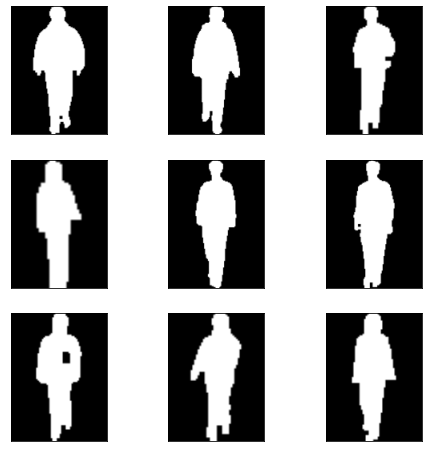

In [34]:
def imshow(img):
    img = img 
    plt.imshow(np.transpose(img, (1, 2, 0)),cmap='gray',vmax=1) 


#Obtain one batch of training images
dataiter = iter(dl)
images = dataiter.next()
images = images.numpy() # convert images to numpy for display

#Plot the images
fig = plt.figure(figsize=(8, 8))
# display 20 images
for idx in np.arange(9):
    ax = fig.add_subplot(3, 3, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    # ax.set_title(classes[labels[idx]])

In [81]:
dataiter = iter(test_dl)
images = dataiter.next()

model = model.float()

#Sample outputs
output = model(images)
images = images.numpy()
batch_size = 32
output = output.view(batch_size, 1, 160, 120)
output = output.detach().numpy()

#Original Images
print("Original Images")
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
plt.show()

#Reconstructed Images
print('Reconstructed Images')
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(output[idx])
plt.show() 

In [69]:
ae = ae.float()
torch.save(ae.state_dict(), '/home/ishikaa/Desktop/Repos/Gait-Occlusion-GAN/encoder_dict')

In [71]:
device = torch.device('cpu')
model = Autoencoder()
model.load_state_dict(torch.load('/home/ishikaa/Desktop/Repos/Gait-Occlusion-GAN/encoder_dict', map_location=device))

<All keys matched successfully>

In [61]:
images = images.double()

In [62]:
images.dtype

torch.float64

In [65]:
images = images.to(torch.double)

In [67]:
images.dtype

torch.float64